In [9]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [10]:
# Cargar el dataset desde el archivo pickle
"""""""""
archivo_pickle = 'datosFERgeneradas.pkl'

with open(archivo_pickle, 'rb') as f:
    df_imagenes = pickle.load(f)

# Visualizar la distribución inicial de etiquetas
plt.figure(figsize=(8, 5))
df_imagenes['Etiqueta'].value_counts().plot(kind='bar')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución Inicial de Etiquetas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
"""""""""

df_imagenes = pd.read_hdf('BD_Emotions_ForCNN.h5')

/tmp/ipykernel_143786/223395640.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_imagenes_reducido = df_imagenes.groupby('Etiqueta').apply(lambda x: x.sample(min(len(x), 5000))).reset_index(drop=True)


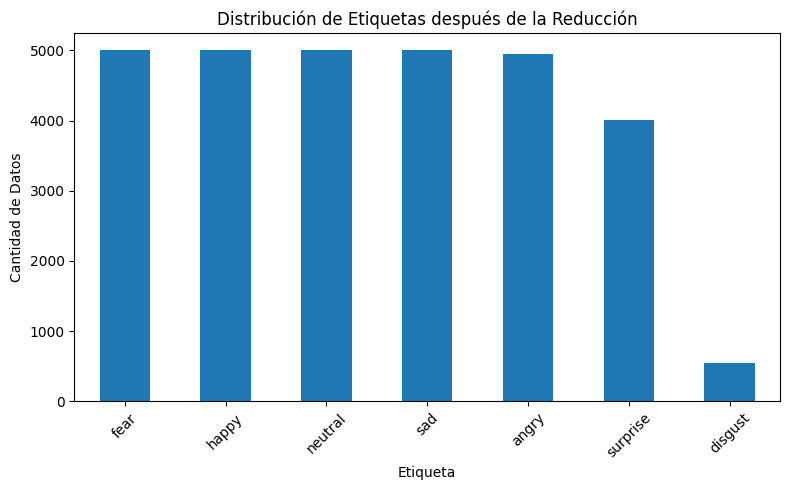

In [11]:
# Seleccionar 1000 muestras de cada etiqueta
df_imagenes_reducido = df_imagenes.groupby('Etiqueta').apply(lambda x: x.sample(min(len(x), 5000))).reset_index(drop=True)

# Verificar la distribución después de la reducción
plt.figure(figsize=(8, 5))
df_imagenes_reducido['Etiqueta'].value_counts().plot(kind='bar')
plt.xlabel('Etiqueta')
plt.ylabel('Cantidad de Datos')
plt.title('Distribución de Etiquetas después de la Reducción')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
df_imagenes.head()

,Imagen,Caracteristicas,Rostro,Etiqueta
0,"[[[178, 178, 178], [194, 194, 194], [206, 206,...",None,None,surprise
1,"[[[87, 87, 87], [92, 92, 92], [69, 69, 69], [5...",None,None,surprise
2,"[[[126, 126, 126], [129, 129, 129], [136, 136,...",None,None,surprise
3,"[[[183, 183, 183], [186, 186, 186], [172, 172,...",None,None,surprise
4,"[[[251, 251, 251], [250, 250, 250], [249, 249,...",None,None,surprise


<class 'numpy.ndarray'>
(48, 48, 3)


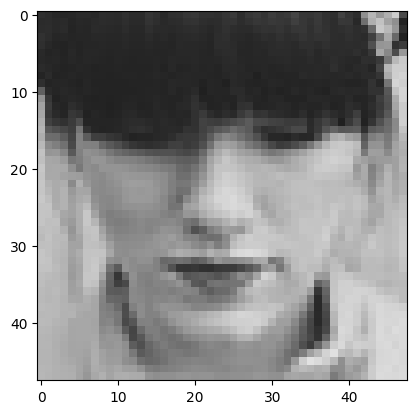

In [13]:
# Separar las características y etiquetas
X = np.array(df_imagenes['Imagen'])
y = df_imagenes['Etiqueta']

# Codificar las etiquetas
etiquetas = y.unique()
y_encoded = pd.Categorical(y, categories=etiquetas).codes

# Dividir el dataset en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2,stratify=y_encoded, random_state=42)
# Convertir las etiquetas a formato one-hot
y_train_one_hot = to_categorical(y_train)
y_val_one_hot = to_categorical(y_val)
print(type(X_train))
print(X_train[4].shape)
import matplotlib.pyplot as plt

# Mostrar la primera imagen de X_train
plt.imshow(X_train[3700])
plt.show()

  Etiqueta Original  Código
0          surprise       0
1          surprise       0
2          surprise       0
3          surprise       0
4          surprise       0
      Etiqueta Original  Código
0              surprise       0
4002            neutral       1
10200             happy       2
19189           disgust       3
19736             angry       4
24689               sad       5
30766              fear       6
<class 'numpy.ndarray'>
(48, 48, 3)


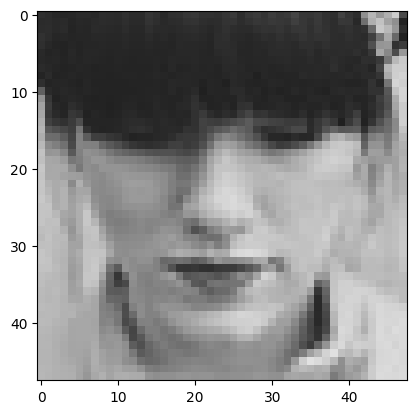

In [14]:
# Crear un DataFrame para mostrar las etiquetas originales y sus codificaciones
df_encoded = pd.DataFrame({'Etiqueta Original': y, 'Código': y_encoded})

# Mostrar las primeras filas del DataFrame
print(df_encoded.head())

# Ver todas las etiquetas únicas y sus códigos
unique_labels = df_encoded.drop_duplicates().sort_values(by='Código')
print(unique_labels)

# Mostrar el tipo y forma de una muestra de X_train
print(type(X_train))
print(X_train[4].shape)

# Mostrar una imagen de X_train
plt.imshow(X_train[3700])
plt.show()


(60, 60, 3)


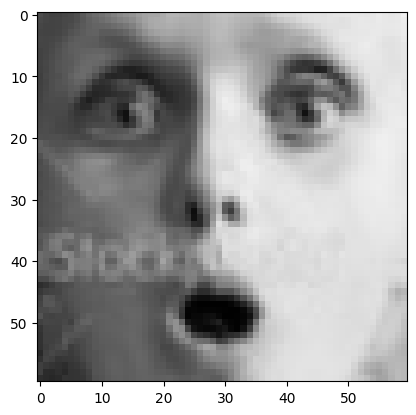

In [15]:
# Define el tamaño deseado para las imágenes
nuevo_tamano = (60, 60)

# Redimensiona todas las imágenes en X_train al mismo tamaño
X_train_redimensionado = [cv2.resize(img, nuevo_tamano) for img in X_train]
X_val_redimensionado = [cv2.resize(img, nuevo_tamano) for img in X_val]
print(X_train_redimensionado[50].shape)
plt.imshow(X_train_redimensionado[3000])
plt.show()

In [16]:
# Convertir las imágenes a arrays numpy 
X_train = np.array([np.array(img) for img in X_train_redimensionado])
X_val = np.array([np.array(img) for img in X_val_redimensionado])

# Normalizar las imágenes dividiendo por 255.0
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0

In [17]:
# Definir el modelo de red neuronal convolucional (CNN)
model = tf.keras.Sequential([
    #tf.keras.layers.Conv2D(16, (3, 3), activation='LeakyReLU',input_shape=(52, 52, 3)),
    tf.keras.layers.Conv2D(32, (5, 5), activation='elu',input_shape=(60, 60, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (5, 5), activation='elu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (5, 5), activation='elu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(500, activation='elu'),
    tf.keras.layers.Dense(len(etiquetas), activation='softmax')  # Capa de salida con activación softmax
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

/home/waldos/.local/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-05-27 09:22:19.168632: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-27 09:22:19.208267: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 56, 56, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │       102,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │     2,048,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,507 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,976,423 (11.35 MB)

 Trainable params: 2,976,423 (11.35 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Entrenar el modelo con el callback de TensorBoard
history = model.fit(X_train, y_train_one_hot,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_val, y_val_one_hot),
                    verbose=1,
                    )

2024-05-27 09:22:19.598590: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1240228800 exceeds 10% of free system memory.
2024-05-27 09:22:20.401055: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1240228800 exceeds 10% of free system memory.


Epoch 1/20


I0000 00:00:1716826942.099020  144954 service.cc:145] XLA service 0x7fb32c006950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716826942.099059  144954 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti with Max-Q Design, Compute Capability 7.5
2024-05-27 09:22:22.130338: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-27 09:22:22.251055: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 13/449 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.1525 - loss: 4.7701

I0000 00:00:1716826945.208495  144954 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


449/449 ━━━━━━━━━━━━━━━━━━━━ 15s 24ms/step - accuracy: 0.3013 - loss: 2.1298 - val_accuracy: 0.4434 - val_loss: 1.4608
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.4456 - loss: 1.4584 - val_accuracy: 0.4512 - val_loss: 1.4148
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.4789 - loss: 1.3604 - val_accuracy: 0.4876 - val_loss: 1.3250
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5036 - loss: 1.2869 - val_accuracy: 0.5056 - val_loss: 1.2926
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5430 - loss: 1.2028 - val_accuracy: 0.5111 - val_loss: 1.2754
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.5735 - loss: 1.1312 - val_accuracy: 0.5389 - val_loss: 1.2269
Epoch 7/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6075 - loss: 1.0439 - val_accuracy: 0.5306 - val_loss: 1.2590
Epoch 8/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.6402 - loss: 0.9504 - val_accuracy: 0.55

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


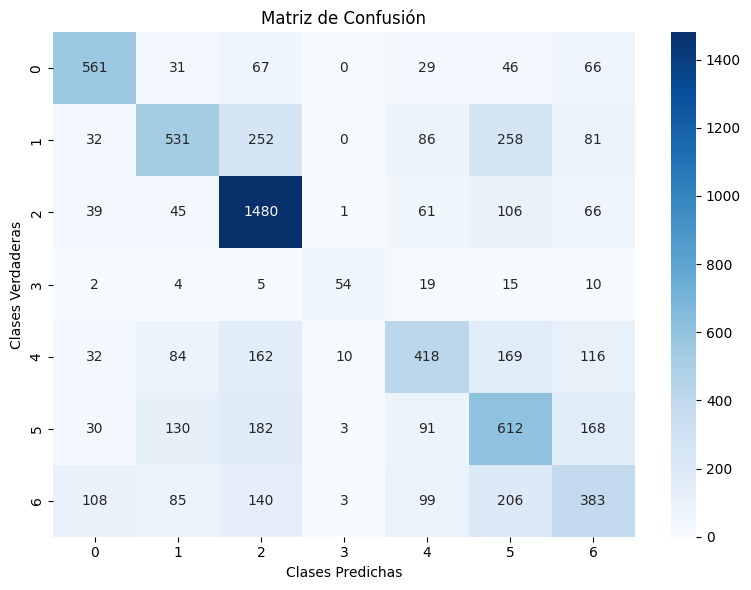

In [19]:
# Obtener las predicciones del conjunto de validación
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
# Calcular la matriz de confusión
conf_mat = confusion_matrix(np.argmax(y_val_one_hot, axis=1), y_pred_classes)
# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Clases Predichas')
plt.ylabel('Clases Verdaderas')
plt.title('Matriz de Confusión')
plt.tight_layout()
plt.show()

In [20]:
# Guardar el modelo
model.save('modelo_cnnFER7.h5')